In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Random Forest Method

#### Gini Impurity Calculation
Gini impurity measures how mixed the classes are within a node. It is computed as:

$$
\text{Gini impurity} = 1 - \sum_{i=1}^{k} p_i^2
$$

Where:

- $p_i$ = proportion of samples belonging to class \( i \)  
- $k$ = total number of classes  

A Gini value of 0 indicates a perfectly pure node (all samples belong to one class), while higher values indicate more class mixing.

#### Information Gain (Split Criterion)

Decision trees choose the split that produces the largest reduction in impurity.  
Information gain is defined as:

$$
\text{Information Gain} = H(\text{parent}) - \sum_{j=1}^{m} 
\frac{n_j}{n} H(\text{child}_j)
$$

Where:

- $H$ is the impurity measure (Gini in this project),
- $n$ is the number of samples in the parent node,
- $n_j$ is the number of samples in child node $j$,
- $m$ is the number of child nodes.

The split with the highest information gain is selected.

### Baseline Random Forest Model
This is run on the cleaned/normalized data as well as sklearn default parameters. This gives us an idea of how this model may perform and potential hyperparameters to focus on during fine-tuning.

In [2]:
from sklearn.model_selection import train_test_split

# load data
df_norm = pd.read_csv("../../data/processed/winequality-red-normalized.csv")

# split into features and target
X_norm = df_norm.drop(columns=['quality'])
y_norm = df_norm['quality']

X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y_norm, test_size=0.2, random_state=42, stratify=y_norm
)

In [3]:
from sklearn.ensemble import RandomForestClassifier

# fit baseline random forest
rf_baseline = RandomForestClassifier(random_state=42)

rf_baseline.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [4]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = rf_baseline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.684375
F1 Score: 0.40597237221330523


In [5]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report

,precision,recall,f1-score,support
3,0.000000,0.000000,0.000000,2.000000
4,0.000000,0.000000,0.000000,11.000000
5,0.725352,0.757353,0.741007,136.000000
6,0.643836,0.734375,0.686131,128.000000
7,0.724138,0.525000,0.608696,40.000000
8,0.500000,0.333333,0.400000,3.000000
accuracy,0.684375,0.684375,0.684375,0.684375
macro avg,0.432221,0.391677,0.405972,320.000000
weighted avg,0.661014,0.684375,0.669218,320.000000


The random forest baseline model performs well on the most common wine qualities (5 and 6), achieving F1 scores of above 0.66, meaning that it's doing a pretty good job at correctly identifying the class while balancing false positives and false negatives. It struggles more with the minority classes (3, 4, and 8) due to the class imbalance present. The overall accuracy of 68.4% is pretty strong as a baseline for this dataset, but further fine-tuning is needed to improve performance further. However, the overall macro F1 score of 0.40 indicates that the model is again, performing poorly across all classes, indicating issues with minority classes.

### Improving the baseline model
Next, we will perform Grid Search Cross Validation on each of the three datasets (our original, PCA, and interaction term).

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [7]:
datasets = {
    "normalized": pd.read_csv("../../data/processed/winequality-red-normalized.csv"),
    "pca": pd.read_csv("../../data/processed/winequality-red-pca.csv"),
    "interactions": pd.read_csv("../../data/processed/winequality-red-interactions.csv")
}

In [8]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 15, 25, 50],
    "max_features": ['sqrt', 'log2', None],
    "class_weight": [None, "balanced"]
}


normalized dataset
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'n_estimators': 100}
CV Macro F1: 0.3523 (+/- 0.0400)
Test Accuracy: 0.6906
Test Macro F1: 0.4132

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.73      0.77      0.75       136
           6       0.65      0.72      0.68       128
           7       0.74      0.57      0.65        40
           8       0.50      0.33      0.40         3

    accuracy                           0.69       320
   macro avg       0.44      0.40      0.41       320
weighted avg       0.67      0.69      0.68       320



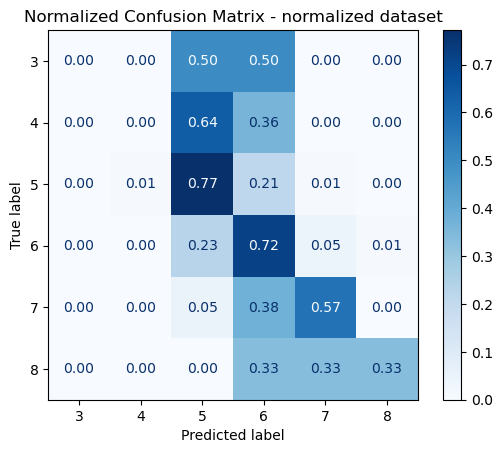


pca dataset
Best parameters: {'class_weight': None, 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 50}
CV Macro F1: 0.3625 (+/- 0.0693)
Test Accuracy: 0.6562
Test Macro F1: 0.3880

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.69      0.76      0.73       136
           6       0.62      0.68      0.65       128
           7       0.72      0.45      0.55        40
           8       0.50      0.33      0.40         3

    accuracy                           0.66       320
   macro avg       0.42      0.37      0.39       320
weighted avg       0.64      0.66      0.64       320



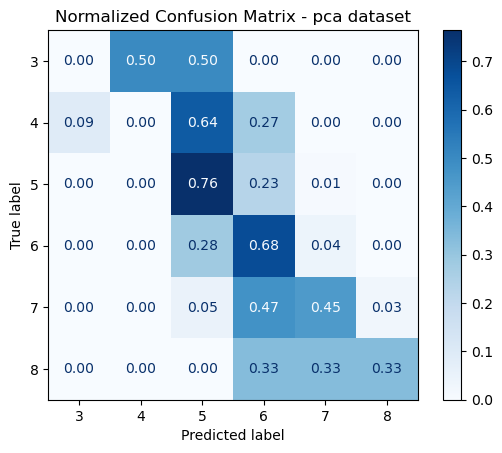


interactions dataset
Best parameters: {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}
CV Macro F1: 0.3477 (+/- 0.0491)
Test Accuracy: 0.6844
Test Macro F1: 0.4018

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.73      0.78      0.75       136
           6       0.64      0.72      0.68       128
           7       0.69      0.50      0.58        40
           8       0.50      0.33      0.40         3

    accuracy                           0.68       320
   macro avg       0.43      0.39      0.40       320
weighted avg       0.66      0.68      0.67       320



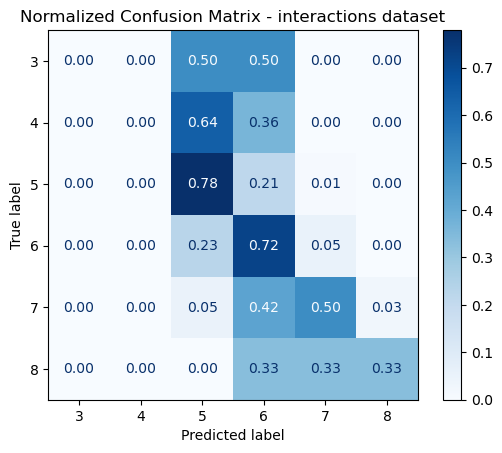

In [11]:
results_table = []

for name, df in datasets.items():
    print(f"\n{name} dataset")

    # split into X and y
    X = df.drop(columns=["quality"])
    y = df["quality"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # grid search
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        scoring="f1_macro",
        cv=5,
        n_jobs=-1,
        return_train_score=False
    )

    grid.fit(X_train, y_train)

    best_params = grid.best_params_
    best_cv_score = grid.best_score_
    cv_std = grid.cv_results_['std_test_score'][grid.best_index_]

    print("Best parameters:", best_params)
    print(f"CV Macro F1: {best_cv_score:.4f} (+/- {cv_std:.4f})")

    # train best
    best_model = RandomForestClassifier(**best_params, random_state=42)
    best_model.fit(X_train, y_train)

    # predict
    y_pred = best_model.predict(X_test)

    # metrics
    test_acc = accuracy_score(y_test, y_pred)
    test_macro_f1 = f1_score(y_test, y_pred, average="macro")

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Macro F1: {test_macro_f1:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # normalized confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
    disp.plot(cmap="Blues", values_format=".2f")
    plt.title(f"Normalized Confusion Matrix - {name} dataset")
    plt.show()

    # store results in table
    results_table.append({
        "Dataset": name,
        "CV Macro F1 (mean)": round(best_cv_score, 4),
        "CV Macro F1 (std)": round(cv_std, 4),
        "Test Accuracy": round(test_acc, 4),
        "Test Macro F1": round(test_macro_f1, 4)
    })

results_df = pd.DataFrame(results_table)

In [12]:
results_df

,Dataset,CV Macro F1 (mean),CV Macro F1 (std),Test Accuracy,Test Macro F1
0,normalized,0.3523,0.0400,0.6906,0.4132
1,pca,0.3625,0.0693,0.6562,0.3880
2,interactions,0.3477,0.0491,0.6844,0.4018
